# Pytorch Custom Dataset
https://www.learnpytorch.io/04_pytorch_custom_datasets/

## 1. Get the Data 

In [1]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

Did not find data\pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


## 2. Data Preparation 

The goal will be to take this data storage structure and turn it into a dataset usable with PyTorch.

In [14]:
import os 
def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.
    Args:
        dir_path (str or pathlib.Path): target directory
    
    Returns:
        A print out of:
        number of subdiretories in dir_path
        number of images (files) in each subdirectory
        name of each subdirectory
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

         


In [15]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


In [17]:
# Setup train and testing path 
train_dir = image_path/"train"
test_dir = image_path/"test"

### 2.1 Visualize an image 

1. Get all of the image paths using pathlib.Path.glob() to find all of the files ending in .jpg.
2. Pick a random image path using Python's random.choice().
3. Get the image class name using pathlib.Path.parent.stem.
4. And since we're working with images, we'll open the random image path using PIL.Image.open() (PIL stands for Python Image Library).
5. We'll then show the image and print some metadata.

data\pizza_steak_sushi\test\pizza
Random image path: data\pizza_steak_sushi\test\pizza\971934.jpg
Image class: pizza
Image height: 512
Image width: 512


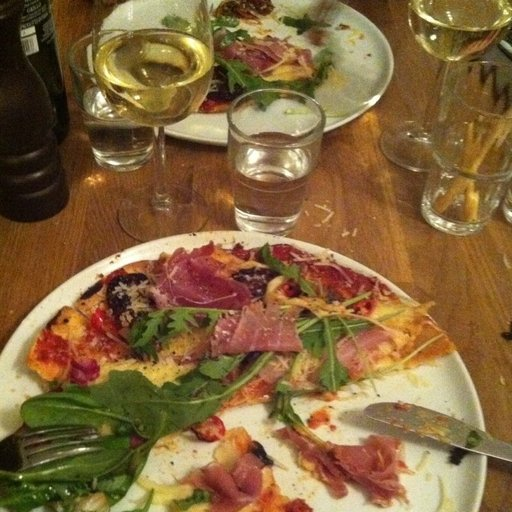

In [22]:
import random 
from PIL import Image 

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
print(random_image_path.parent)


# 4. Open image
img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

We can do the same with `matplotlib.pyplot.imshow()`, except we have to convert the image to a NumPy array first.

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

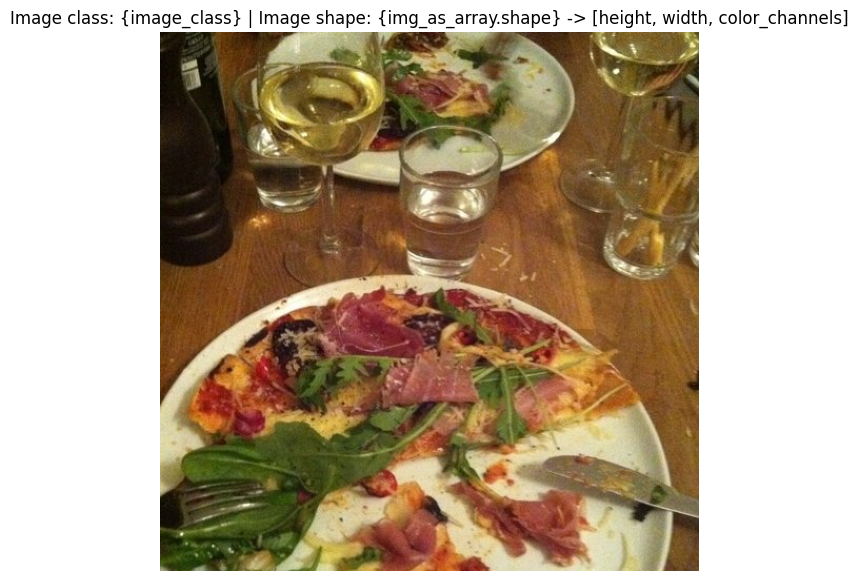

In [24]:
import numpy as np 
import matplotlib.pyplot as plt 

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title("Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

## 3. Transforming Data

1. Turn it into tensors (numerical representations of our images).
2. Turn it into a torch.utils.data.Dataset and subsequently a torch.utils.data.DataLoader, we'll call these Dataset and DataLoader for short.

In [25]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

We've got folders of images but before we can use them with PyTorch, we need to convert them into tensors.

One of the ways we can do this is by using the `torchvision.transforms` module.

`torchvision.transforms` contains many pre-built methods for formatting images, turning them into tensors and even manipulating them for data augmentation (the practice of altering data to make it harder for a model to learn, we'll see this later on) purposes .

To get experience with `torchvision.transforms`, let's write a series of transform steps that:

1. Resize the images using `transforms.Resize()` (from about 512x512 to 64x64, the same shape as the images on the CNN Explainer website).
2. Flip our images randomly on the horizontal using `transforms.RandomHorizontalFlip()` (this could be considered a form of data augmentation because it will artificially change our image data).
3. Turn our images from a PIL image to a PyTorch tensor using `transforms.ToTensor()`.


We can compile all of these steps using `torchvision.transforms.Compose()`.

1. `transforms.Resize(size=(64,64))`

* Fungsi: ubah ukuran semua gambar jadi 64×64 pixel.

* Kenapa harus resize?
 
    * Consistency: Model CNN butuh input dengan ukuran tetap. Kalau ada gambar 32×32 dan ada 128×128, model bakal error.

    * Efisiensi: Gambar gede → butuh komputasi lebih. Resize bisa mempercepat training.

    * Trade-off: gambar kecil → informasi detail berkurang, tapi training lebih cepat.

👉 Contoh: kalau FashionMNIST (28×28) diresize jadi 64×64, kita kasih lebih banyak pixel ke model untuk belajar pola.

2. `transforms.RandomHorizontalFlip(p=0.5)`

* Fungsi: membalik gambar secara horizontal (kiri ↔ kanan).
 
* p=0.5 artinya: ada 50% kemungkinan gambar dibalik, 50% tetap sama.
 
* Kenapa dipakai?
 
    * Augmentasi data: bikin variasi gambar baru tanpa nambah dataset asli.

    * Cegah overfitting: model nggak cuma hafal posisi objek, tapi ngerti polanya.

    * Contoh real: kucing yang menghadap kiri dan kucing menghadap kanan itu tetap kucing → model harus bisa mengenali keduanya.

Kalau p=1.0 → semua gambar selalu dibalik.
Kalau p=0.0 → tidak ada gambar yang dibalik (efeknya sama kayak nggak dipakai).

In [28]:
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size = (64,64)),
    # flip the images randomly on horizontal 
    transforms.RandomHorizontalFlip(p = 0.5) , # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor()]
)

In [ ]:
def plot_transformed_images(image_path, transforms, n =3, seed = 42):